# Variance-level plots

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinAnalysis import *
from utils.BasinPlot import *

In [6]:
ls = [6, 7, 8, 9, 10]

In [7]:
grid_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    grid_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        } )

Test

In [8]:
source_path = "/home/florianb/havvarsel/multilevelDA/scripts/VarianceLevelsDA/Basin/2023-08-22T16_51_35"

In [9]:
states = [[np.load(source_path+"/SLensemble_"+str(l_idx)+"_"+str(t)+".npy") for l_idx in range(len(ls))] for t in [0, 15*60, 3600, 6*3600, 12*3600] ]

In [10]:
coarse_states = [[np.load(source_path+"/SLensemble_"+str(l_idx)+"_"+str(t)+"_coarse.npy") for l_idx in range(1,len(ls))] for t in [0, 15*60, 3600, 6*3600, 12*3600] ]

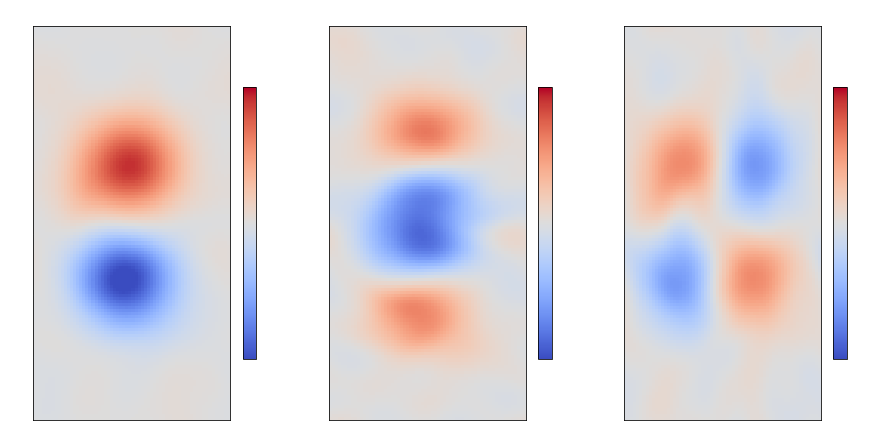

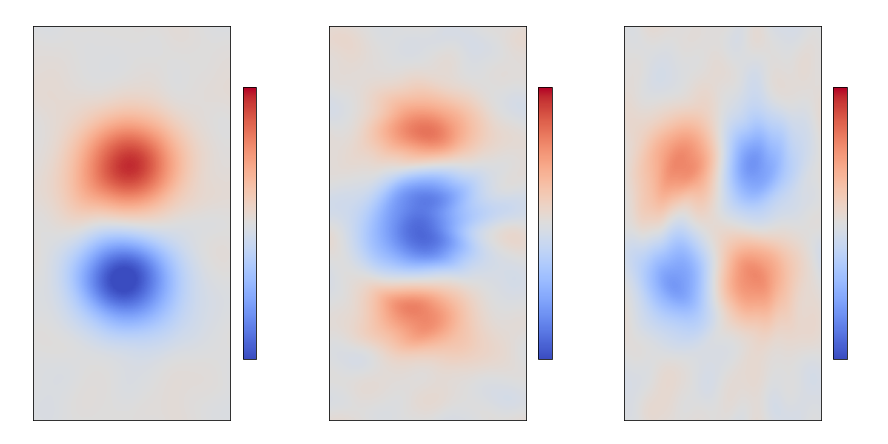

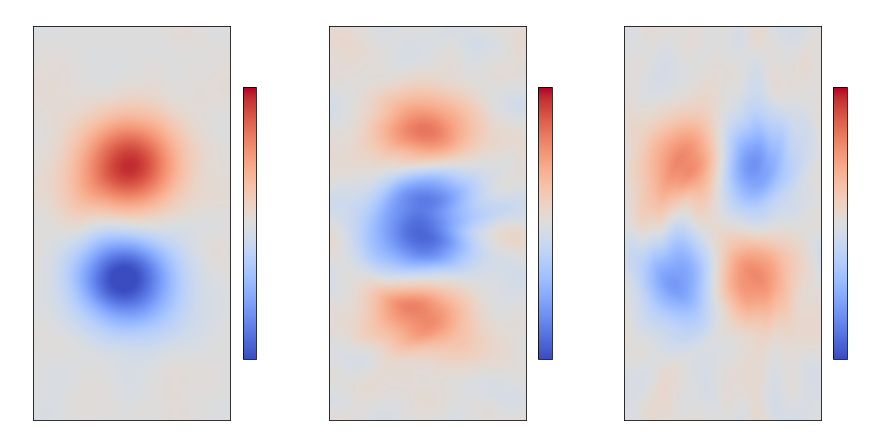

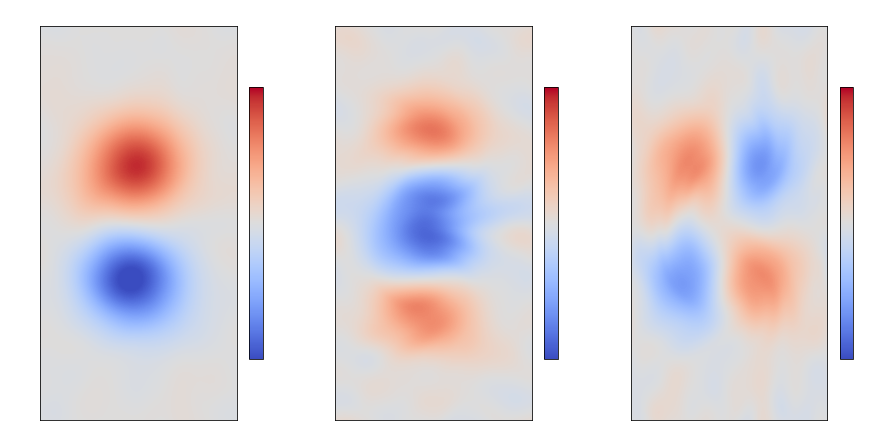

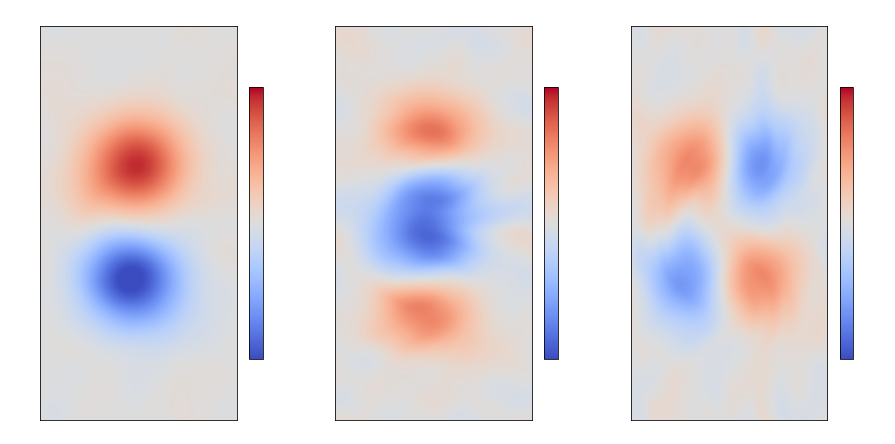

In [11]:
for t in range(5):
    imshow3(np.average(states[-2][t],axis=-1))

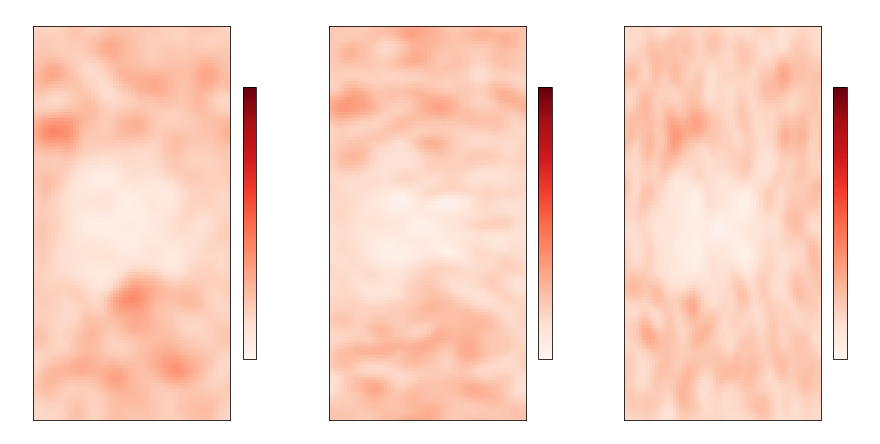

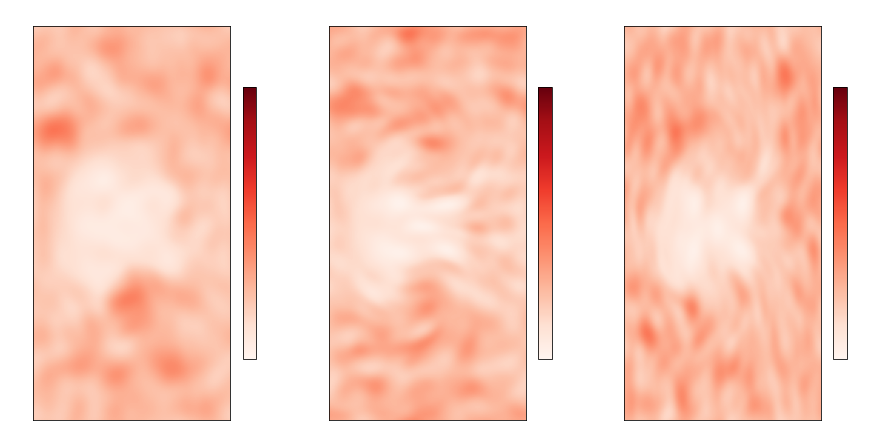

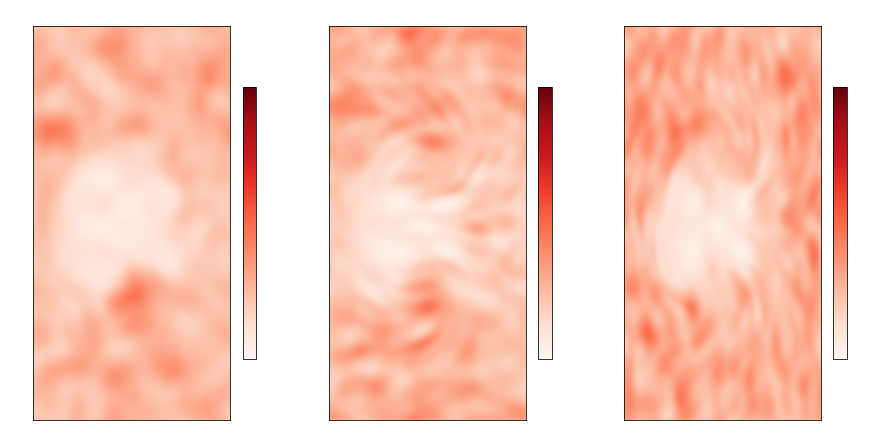

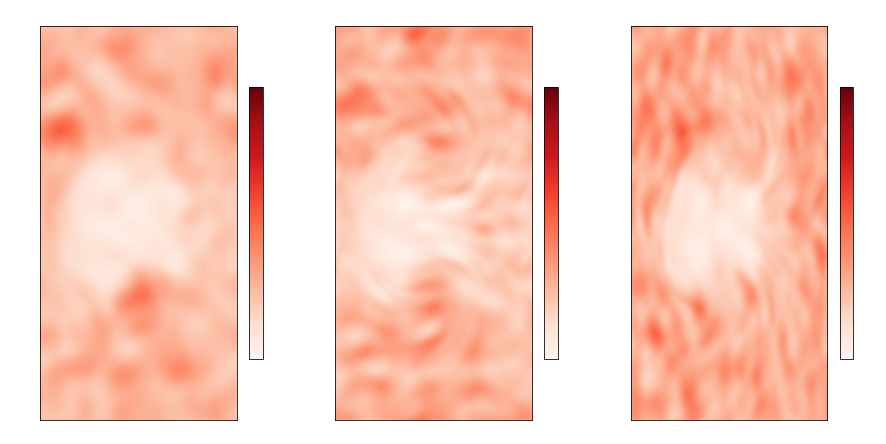

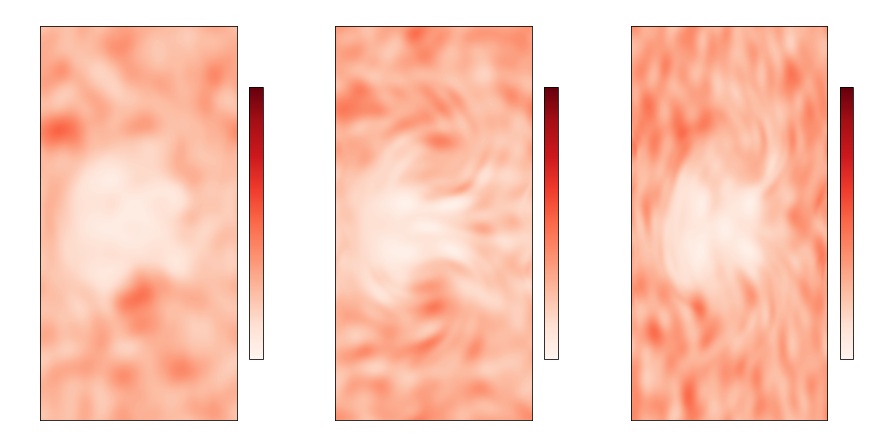

In [12]:
for t in range(5):
    imshow3var(np.var(states[-2][t],axis=-1))

In [13]:
from utils.BasinSL import *

def g_functional(SL_ensemble):
    """
    L_g functional as in notation of Kjetil's PhD thesis.
    This should be the functional that is under investigation for the variance level plot

    Returns a ndarray of same size as SL_ensemble (3, ny, nx, Ne)
    """
    return (SL_ensemble - np.mean(SL_ensemble, axis=-1)[:,:,:,np.newaxis])**2
    # return SL_ensemble


def L2norm(field, lvl_grid_args):
    """
    integral_D(f dx)
    where D are uniform finite volumes

    Input:
    field           - ndarray of shape (3,ny,nx,..)
    lvl_grid_args   - dict with nx, ny and dx, dy information

    Output:
    L2norm          - ndarray of shape (3,...)
    """
    # assert field.shape[1:3] == (lvl_grid_args["ny"], lvl_grid_args["nx"]), "field has wrong resolution"
    return np.sqrt(np.sum((field)**2 * lvl_grid_args["dx"]*lvl_grid_args["dy"], axis=(1,2)))


def L1norm(field, lvl_grid_args):
    """
    integral_D(f dx)
    where D are uniform finite volumes

    Input:
    field           - ndarray of shape (3,ny,nx,..)
    lvl_grid_args   - dict with nx, ny and dx, dy information

    Output:
    L1norm          - ndarray of shape (3,...)
    """
    # assert field.shape[1:3] == (lvl_grid_args["ny"], lvl_grid_args["nx"]), "field has wrong resolution"
    return np.sum(np.abs(field) * lvl_grid_args["dx"]*lvl_grid_args["dy"], axis=(1,2))


def Enorm(field, lvl_grid_args):
    """
    integral_D(f dx)
    where D are uniform finite volumes

    Input:
    field           - ndarray of shape (3,ny,nx,..)
    lvl_grid_args   - dict with nx, ny and dx, dy information

    Output:
    L1norm          - ndarray of shape (3,...)
    """
    # assert field.shape[1:3] == (lvl_grid_args["ny"], lvl_grid_args["nx"]), "field has wrong resolution"
    return np.mean(field, axis=(1,2))


norm = L2norm

In [14]:
# Read files
Ts = [0, 15*60, 3600, 6*3600, 12*3600]
states = [[np.load(source_path+"/SLensemble_"+str(l_idx)+"_"+str(t)+".npy") for l_idx in range(len(ls))] for t in Ts ]
coarse_states = [[np.load(source_path+"/SLensemble_"+str(l_idx)+"_"+str(t)+"_coarse.npy") for l_idx in range(1,len(ls))] for t in Ts ]


vars_listTs = []
diff_vars_listTs = []

center_vars_listTs = []
center_diff_vars_listTs = []
        

for t_idx in range(len(Ts)):
    vars_list = []
    diff_vars_list = []

    center_vars_list = []
    center_diff_vars_list = []
    for l_idx in range(len(ls)):
        vars_list.append(norm(np.var(g_functional(states[t_idx][l_idx]), axis=-1), grid_args_list[l_idx]))

        center_N = int(grid_args_list[l_idx]["nx"]/4)
        center_x = int(grid_args_list[l_idx]["nx"]/2)
        center_y = int(grid_args_list[l_idx]["ny"]/2)
            
        center_vars_list.append( norm(np.var(g_functional(states[t_idx][l_idx])[:, center_y-center_N:center_y+center_N, center_x-center_N:center_x+center_N,:], axis=-1), grid_args_list[l_idx]) )
        
        if l_idx > 0:
            diff_vars_list.append(norm(np.var(g_functional(states[t_idx][l_idx]) - g_functional(coarse_states[t_idx][l_idx-1]).repeat(2,1).repeat(2,2), axis=-1), grid_args_list[l_idx]))
            center_diff_vars_list.append(norm(np.var((g_functional(states[t_idx][l_idx]) - g_functional(coarse_states[t_idx][l_idx-1]).repeat(2,1).repeat(2,2))[:, center_y-center_N:center_y+center_N, center_x-center_N:center_x+center_N,:], axis=-1), grid_args_list[l_idx]))
    vars_listTs.append(vars_list)
    diff_vars_listTs.append(diff_vars_list)

    center_vars_listTs.append(center_vars_list)
    center_diff_vars_listTs.append(center_diff_vars_list)

In [15]:
t_idx = -2
np.save(source_path+"/center_vars_"+str(Ts[t_idx])+"_"+norm.__name__+".npy", np.array(center_vars_listTs[t_idx]))
np.save(source_path+"/center_diff_vars_"+str(Ts[t_idx])+"_"+norm.__name__+".npy", np.array(center_diff_vars_listTs[t_idx]))

In [16]:
import matplotlib.lines as mlines

def plotLvlVarTs(relative=False, center=False):


    # Plot
    with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        if center:
            fig.suptitle("Variance level plot for center")
        else:
            fig.suptitle("Variance level plot")

        axs[0].set_title("$\eta$", fontsize=15)
        axs[1].set_title("$hu$", fontsize=15)
        axs[2].set_title("$hv$", fontsize=15)

        Nxs = [nx*ny for nx, ny in zip([da["nx"] for da in grid_args_list], [da["ny"] for da in grid_args_list])]

        for T_idx in range(len(vars_list)):
            vars = np.array(vars_listTs[T_idx])
            diff_vars = np.array(diff_vars_listTs[T_idx])
            if center:
                vars = np.array(center_vars_listTs[T_idx])
                diff_vars = np.array(center_diff_vars_listTs[T_idx])

            if relative:
                diff_vars = diff_vars/vars[-1]
                vars = vars/vars[-1]
                axs[0].set_ylim((None,2))
                axs[1].set_ylim((None,2))
                axs[2].set_ylim((None,2))

            for i in range(3):

                if T_idx+1 < len(vars_list):
                    axs[i].loglog(Nxs, vars[:,i], linewidth=3, c="C0", alpha=0.1+0.9*T_idx/len(vars_list))
                    axs[i].loglog(Nxs[1:], diff_vars[:,i], linewidth=3, c="C1", alpha=0.1+0.9*T_idx/len(vars_list))
                
                else:
                    axs[i].loglog(Nxs, vars[:,i], linewidth=3, c="C0", ls="--")
                    axs[i].loglog(Nxs[1:], diff_vars[:,i], linewidth=3, c="C1", ls="--")
                    axs[i].set_xlabel("# grid cells", fontsize=15)

                    handles_var = [mlines.Line2D([], [], c="C0", lw=3, label="$|| Var[u^l] ||_{L^2}$"), 
                                   mlines.Line2D([], [], c="C1", lw=3, label="$|| Var[u^l-u^{l-1}] ||_{L^2}$")]
                    # legend_var = axs[i].legend(handles=handles_var, title="Variances", labelcolor="black", loc=(0.35,0.01), fontsize=12)
                    # axs[i].add_artist(legend_var)

                    axs[i].set_xlabel("# grid cells", fontsize=15)
                    axs[i].set_xticks(Nxs)
                    axs[i].xaxis.grid(True)
                    
                    handles_T = [mlines.Line2D([], [], c="C1", alpha=0.1+0.9*T_idx/len(vars_list), lw=3, label=str(Ts[T_idx])) for T_idx in range(len(vars_list)-1)]
                    handles_T.append( mlines.Line2D([], [], c="C1", alpha=0.1+0.9*T_idx/len(vars_list), lw=3, ls="--", label=str(Ts[-1])) )
                    # axs[i].legend(handles=handles_T, title="Time [s]", fontsize=12, loc=(0.01,0.01))
        

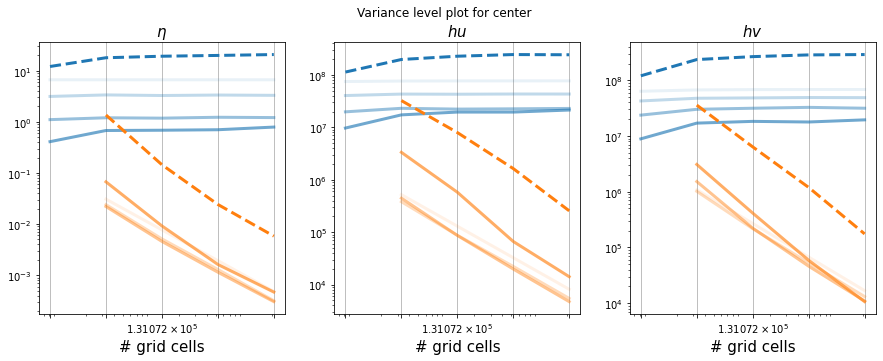

In [17]:
plotLvlVarTs(center=True)

In [18]:
from utils.BasinAnalysis import *

In [19]:
work_path = "/home/florianb/havvarsel/multilevelDA/scripts/PracticalCost/Basin/2023-06-29T14_54_02"

In [20]:
def raw2costsEnsemble(filename):
    rawCosts = np.load(filename)
    return np.mean(np.sort(rawCosts), axis=1)

In [21]:
costsPure = raw2costsEnsemble(work_path+"/costsPureEnsemble.npy")
costsPartnered = raw2costsEnsemble(work_path+"/costsPartneredEnsemble.npy")

In [22]:
analysis = Analysis(grid_args_list, center_vars_listTs[-2], center_diff_vars_listTs[-2], costsPure, costsPartnered)

In [23]:
ML_Ne = analysis.optimal_Ne(tau=1.5e-2)
ML_Ne

array([6959, 1939,  547,  121,   21], dtype=int32)

In [24]:
analysis.work(ML_Ne)/costsPure[-1]

201.945328577701